# <center>ETUDE DES CORRELATIONS</center> #

In [1]:
import pandas as pd
import numpy as np

#élargissement de la visualisation des tableaux pandas
pd.set_option('display.max_columns', None)

#suppression des warnings
import warnings
warnings.filterwarnings('ignore')

#visualisations
import seaborn as sns
import matplotlib.pyplot as plt

#stats
from scipy.stats import pearsonr

#modélisation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.pipeline import Pipeline

# <font color='#5BA69E'>CHARTE GRAPHIQUE</font> ##

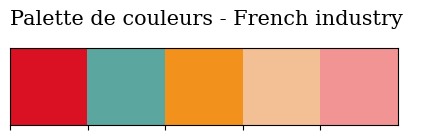

In [2]:
sns.palplot(["#D91122", "#5BA69E", "#F2911B", "#F2C094", "#F29494"])
plt.title("Palette de couleurs - French industry  ",loc='left',fontfamily='serif',fontsize=15,y=1.2)
plt.show()

In [3]:
#ouverture du déscriptif des variables et création d'un dictionnaire pour utilisation ultérieure
desc_var = pd.read_csv('../files/description_variables.csv', sep=';')
desc_var_dic = dict(list(zip(desc_var['CODVAR'], desc_var['Description'])))

# <font color='#5BA69E'>ETUDE DES CORRELATIONS</font> ##

In [4]:
df = pd.read_csv('../files/all_content_2020_v5.csv')

In [5]:
df.shape

(34955, 738)

In [6]:
no_float_dic = {}

for i in df.columns:
    no_float = []
    for j in df[i]:
        try:
            float(j)
        except:
            no_float.append(j)
    if np.size(no_float) > 0:
        no_float_dic[i] = np.size(np.unique(no_float))


In [7]:
no_float_df = pd.DataFrame(no_float_dic.items(), columns=['Col', 'non_float_unique'])

In [8]:
#utilisation du dictionnaire des variables créé en début de notebook
no_float_df['description'] = no_float_df.Col.map(desc_var_dic)

In [9]:
no_float_df

,Col,non_float_unique,description
0,CODGEO,360,Code commune INSEE
1,EU_circo,8,Zone France
2,num_dep,2,Numéro du département
3,nom_commune,32692,Nom de la commune
4,nom_dep,101,Nom du département
5,nom_region,18,Nom de la région
6,num_chef_lieu,1,CODGEO du chef lieu de région
7,nom_chef_lieu,18,Nom du chef lieu de région
8,NBMENFISC20,2,Nombre de ménages fiscaux
9,NBPERSMENFISC20,2,Nombre de personnes dans les ménages fiscaux


**Les index 8 à 34 sont, d'après leur description, des données numériques malgré la présence de non floats**

In [10]:
#transformation du tableau pour n'avoir que les lignes qui nous interessent
no_float_df = no_float_df.iloc[8:,].reset_index(drop=True)

In [11]:
no_float_df

,Col,non_float_unique,description
0,NBMENFISC20,2,Nombre de ménages fiscaux
1,NBPERSMENFISC20,2,Nombre de personnes dans les ménages fiscaux
2,MED20,2,Médiane du niveau vie (€)
3,PIMP20,73,Part des ménages fiscaux imposés (%)
4,TP6020,45,Taux de pauvreté-Ensemble (%)
5,TP60AGE120,51,Taux de pauvreté-moins de 30 ans (%)
6,TP60AGE220,53,Taux de pauvreté-30 à 39 ans (%)
7,TP60AGE320,51,Taux de pauvreté-40 à 49 ans (%)
8,TP60AGE420,43,Taux de pauvreté-50 à 59 ans (%)
9,TP60AGE520,37,Taux de pauvreté-60 à 74 ans (%)


In [12]:
#Nous devons désormais identifier les problèmes et décider des solutions

for i in no_float_df.Col:
    no_float = []
    for j in df[i]:
        try:
            float(j)
        except:
            no_float.append(j) 
    print('colonne', i, ':', np.unique(no_float))

colonne NBMENFISC20 : ['nd' 's']
colonne NBPERSMENFISC20 : ['nd' 's']
colonne MED20 : ['nd' 's']
colonne PIMP20 : ['15,0' '16,0' '17,0' '18,0' '19,0' '20,0' '21,0' '22,0' '23,0' '24,0'
 '25,0' '26,0' '27,0' '28,0' '29,0' '30,0' '31,0' '32,0' '33,0' '34,0'
 '35,0' '36,0' '37,0' '38,0' '39,0' '40,0' '41,0' '42,0' '43,0' '44,0'
 '45,0' '46,0' '47,0' '48,0' '49,0' '50,0' '51,0' '52,0' '53,0' '54,0'
 '55,0' '56,0' '57,0' '58,0' '59,0' '60,0' '61,0' '62,0' '63,0' '64,0'
 '65,0' '66,0' '67,0' '68,0' '69,0' '70,0' '71,0' '72,0' '73,0' '74,0'
 '75,0' '76,0' '77,0' '78,0' '79,0' '80,0' '81,0' '82,0' '83,0' '84,0'
 '86,0' 'nd' 's']
colonne TP6020 : ['10,0' '11,0' '12,0' '13,0' '14,0' '15,0' '16,0' '17,0' '18,0' '19,0'
 '20,0' '21,0' '22,0' '23,0' '24,0' '25,0' '26,0' '27,0' '28,0' '29,0'
 '30,0' '31,0' '32,0' '33,0' '34,0' '35,0' '36,0' '37,0' '38,0' '39,0'
 '41,0' '42,0' '43,0' '44,0' '46,0' '49,0' '5,0' '50,0' '53,0' '6,0' '7,0'
 '8,0' '9,0' 'nd' 's']
colonne TP60AGE120 : ['11,0' '12,0' '13,0' 

colonne PPMINI20 : ['0,2' '0,3' '0,4' '0,5' '0,6' '0,7' '0,8' '0,9' '1,0' '1,1' '1,2' '1,3'
 '1,4' '1,5' '1,6' '1,7' '1,8' '1,9' '10,0' '10,4' '10,5' '10,7' '10,8'
 '11,0' '11,1' '11,4' '11,5' '11,6' '11,7' '12,1' '12,7' '12,8' '12,9'
 '13,0' '13,5' '14,0' '14,2' '14,6' '15,4' '16,2' '16,9' '17,3' '18,8'
 '2,0' '2,1' '2,2' '2,3' '2,4' '2,5' '2,6' '2,7' '2,8' '2,9' '3,0' '3,1'
 '3,2' '3,3' '3,4' '3,5' '3,6' '3,7' '3,8' '3,9' '4,0' '4,1' '4,2' '4,3'
 '4,4' '4,5' '4,6' '4,7' '4,8' '4,9' '5,0' '5,1' '5,2' '5,3' '5,4' '5,5'
 '5,6' '5,7' '5,8' '5,9' '6,0' '6,1' '6,2' '6,3' '6,4' '6,5' '6,6' '6,7'
 '6,8' '6,9' '7,0' '7,1' '7,2' '7,3' '7,4' '7,5' '7,6' '7,7' '7,8' '7,9'
 '8,0' '8,1' '8,2' '8,3' '8,4' '8,5' '8,6' '8,7' '8,8' '8,9' '9,1' '9,2'
 '9,3' '9,4' '9,5' '9,6' '9,7' '9,8' '9,9' 'nd' 's']
colonne PPLOGT20 : ['0,1' '0,2' '0,3' '0,4' '0,5' '0,6' '0,7' '0,8' '0,9' '1,0' '1,1' '1,2'
 '1,3' '1,4' '1,5' '1,6' '1,7' '1,8' '1,9' '2,0' '2,1' '2,2' '2,3' '2,4'
 '2,5' '2,6' '2,7' '2,8' '2,9' '3,0' '

**On note deux types de problèmes**

- Des , au lieu de .
- Des 'nd', ou 's' pour 'non determiné' ou 'secret'

# CONVERSION DES COLONNES EN FLOAT #

In [13]:
for i in no_float_df.Col:
    df[i] = df[i].astype(str)
    df[i] = df[i].str.replace(',', '.')
    df[i] = df[i].replace(['s', 'nd'], np.nan)
    df[i] = df[i].astype(float)

**TP6020 est désomrias un float ou un NaN**

% de NaN dans la variable TP6020

In [14]:
df.TP6020.isna().sum() / len(df)

0.8762694893434416

In [15]:
df.TP6020.isna().value_counts()

True     30630
False     4325
Name: TP6020, dtype: int64

In [16]:
len(df)

34955

In [17]:
df_isna = pd.DataFrame(df.isna().sum().sort_values(ascending=False))

In [18]:
df_isna['desc'] = df_isna.index.map(desc_var_dic)

In [19]:
df_isna.columns = ['isNa', 'desc']

In [20]:
df_isna = df_isna[df_isna.isNa > 0]

In [21]:
pd.set_option('display.max_rows', None)
df_isna.head(200)

,isNa,desc
P19_RP_MIDUR,34843,Maisons ou Immeubles en dur en 2019 (princ)
P19_RP_MIBOIS,34843,Maisons ou Immeubles en bois en 2019 (princ)
P19_RP_CASE,34843,Cases traditionnelles en 2019 (princ)
P19_RP_HABFOR,34843,Habitations de fortune en 2019 (princ)
P19_RP_TTEGOU,34843,Rés princ avec tout à l'égout en 2019 (princ)
P19_RP_CLIM,34843,Rés princ avec pièce climatisée en 2019 (princ)
P19_RP_ELEC,34843,Rés princ avec électricité en 2019 (princ)
P19_RP_EAUCH,34843,Rés princ avec eau chaude en 2019 (princ)
P19_RP_BDWC,34843,Rés princ avec Bain/Douche WC en 2019 (princ)
P19_RP_CHOS,34843,Rés princ avec chauffe-eau solaire en 2019 (pr...


In [22]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'NaN > 29K')

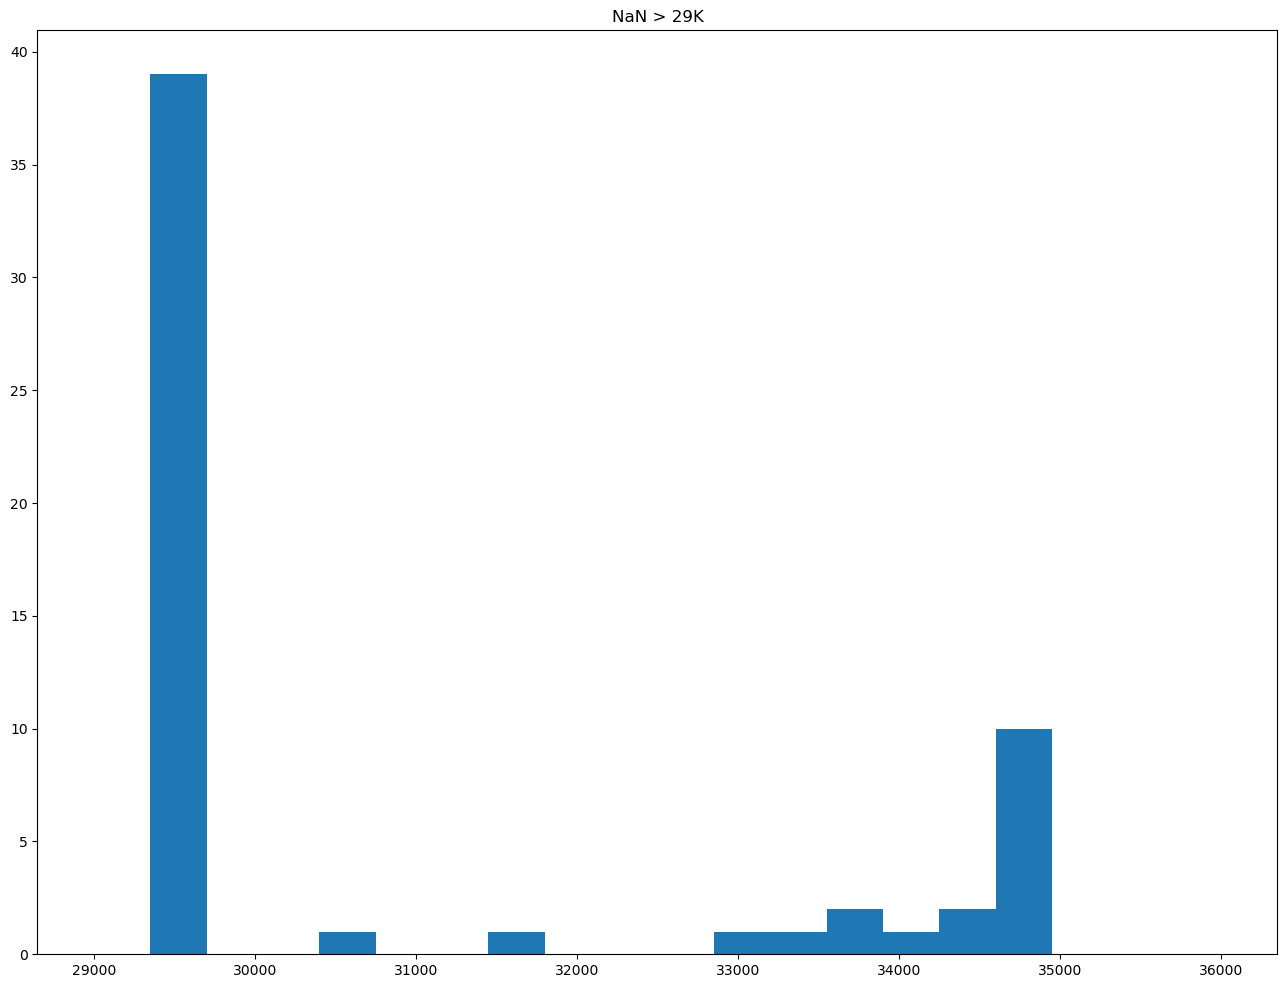

In [23]:
plt.figure(figsize=(16,12))
plt.hist(df_isna.isNa, bins=20, range=(29000,36000))
plt.title('NaN > 29K')

Text(0.5, 1.0, 'NaN > 3K & < 29K')

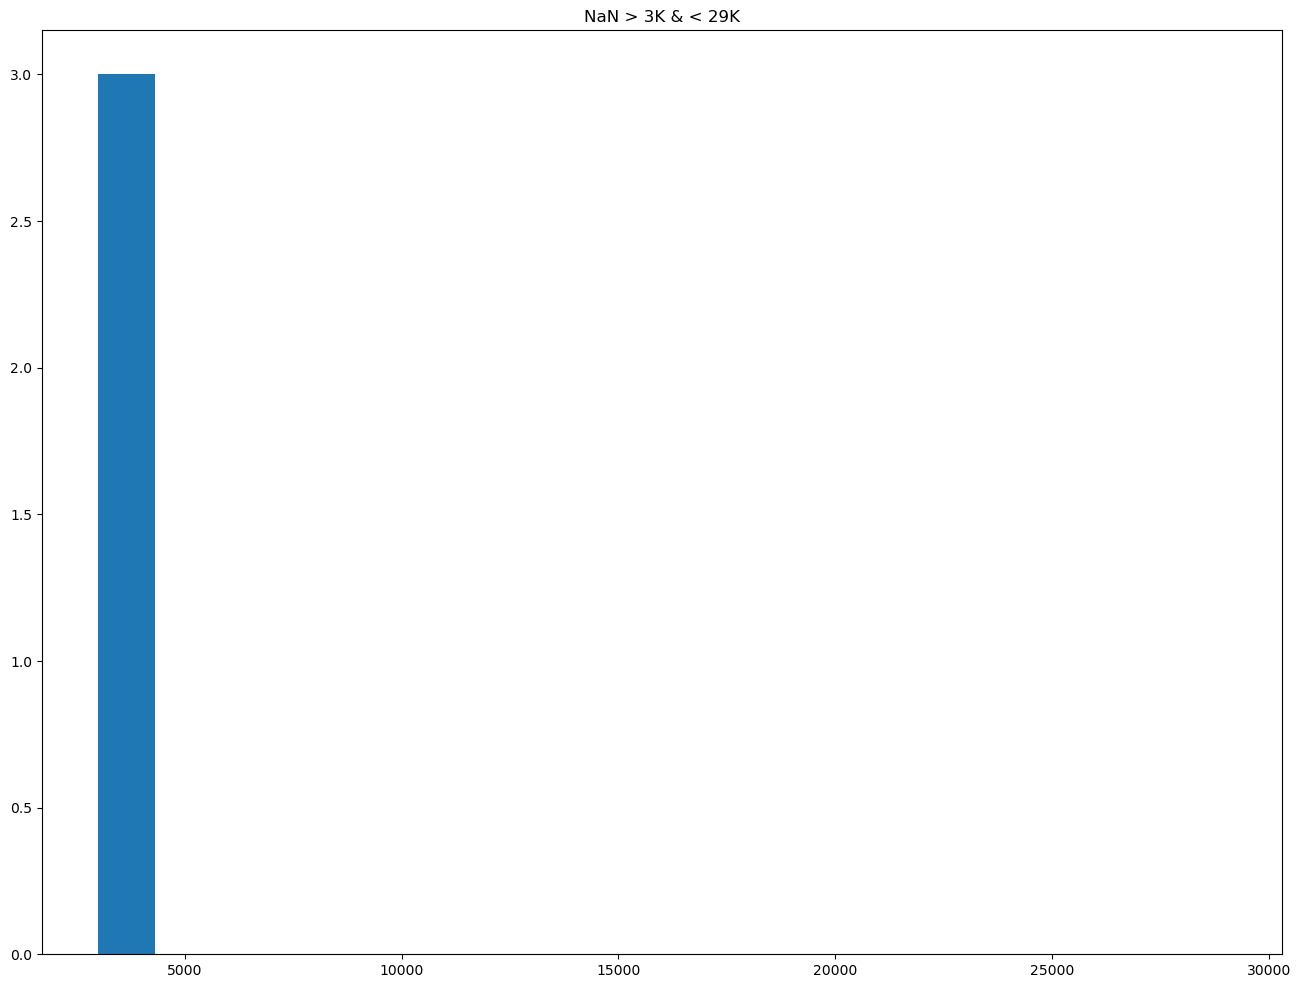

In [24]:
plt.figure(figsize=(16,12))
plt.hist(df_isna.isNa, bins=20, range=(3000,29000))
plt.title('NaN > 3K & < 29K')

Text(0.5, 1.0, 'de 0 à 20 NaN')

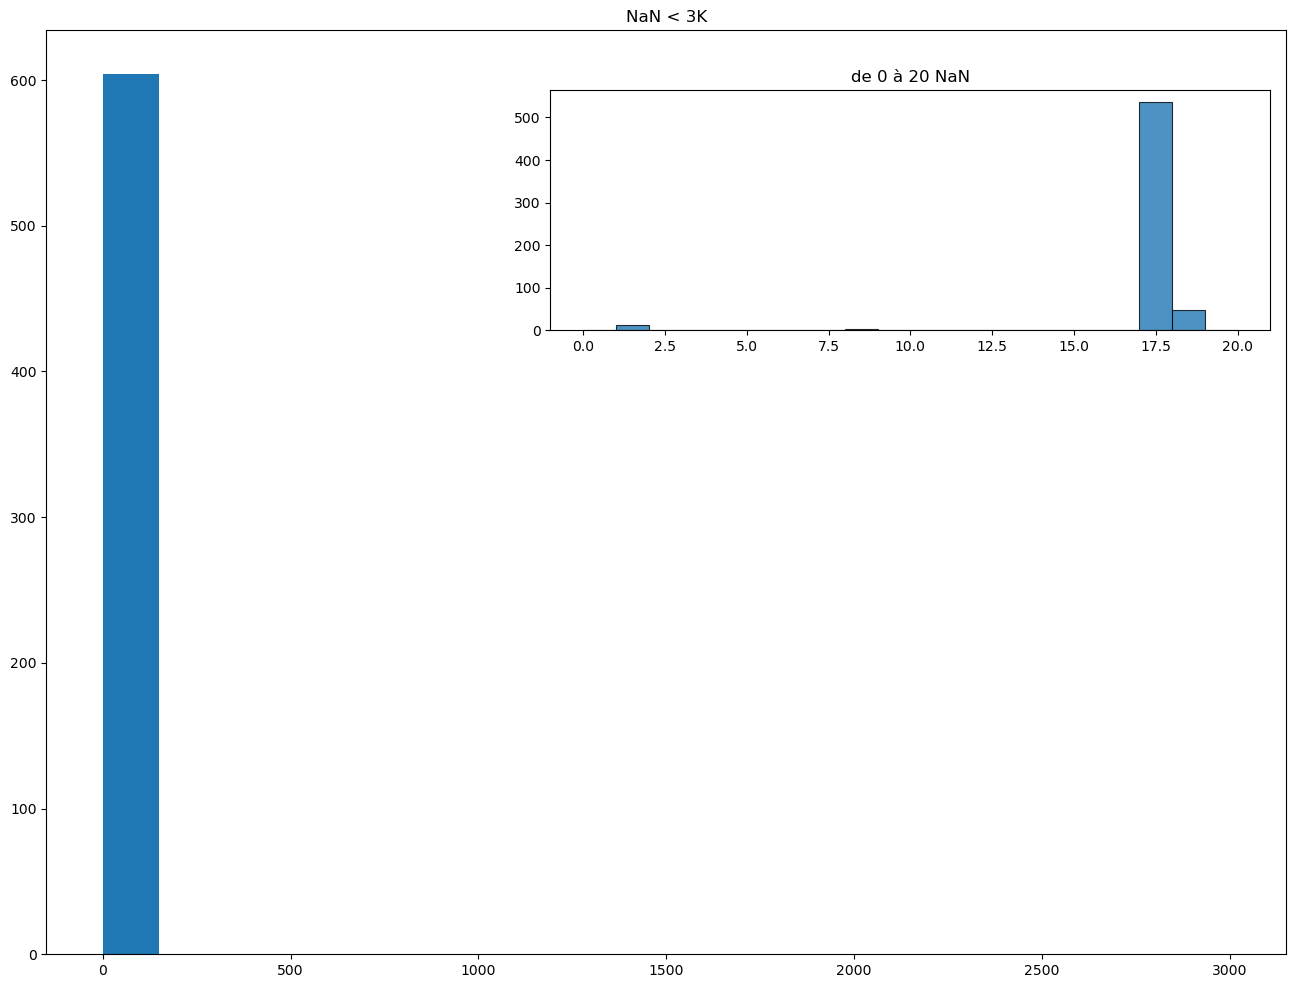

In [25]:
plt.figure(figsize=(16,12))

plt.hist(df_isna.isNa, bins=20, range=(0,3000))
plt.title('NaN < 3K')

ax2 = plt.axes([0.44, 0.63, 0.45, 0.2])
ax2.hist(df_isna.isNa, 
                 bins= 20,
                 range = (0, 20),
                 edgecolor='black',
                 linewidth=0.8,
                 alpha=0.8
                )
ax2.set_title('de 0 à 20 NaN')

On observe donc qu'on peut diviser les variables impactées par les NaN en 3 catégories :

- Pauvres en NaN : < 20 NaN, peut être remplacé par une moyenne ou une médiane
- Contient des NaN : == 3671 NaN, peut être remplacé par une moyenne ou une médiane (mais la MED20 fait l'objet d'un projet de modélisation également de manière à prédire les manquants)
- Riche en NaN : > 29K : variables pouvant représenter un biais et qu'il vaut mieux supprimer (à l'exception de la TP6020)

## Fonction de management des NaN ##

In [26]:
for i in df_isna.itertuples():
    try:
        if (i[1] > 29000) & (i[0] not in ['TP6020', 'MED20']):
            df = df.drop(i[0], axis=1)
        else:
            if (i[0] not in ['TP6020', 'MED20']):
                df[i[0]] = df[i[0]].fillna(df[i[0]].median())
    except:
        print(i[0])
    

In [27]:
df.isna().sum().sort_values(ascending=False).head(10)

TP6020              30630
MED20                3671
P19_FACT1524            0
P19_HACTOCC15P          0
P19_ACTOCC15P           0
P19_SAL15P              0
P19_NSAL15P             0
P19_ACTOCC15P_TP        0
P19_SAL15P_TP           0
P19_HSAL15P_TP          0
dtype: int64

**Il ne nous reste plus que les NaN dans la TP6020 et la MED20, la TP6020 étant la variable cible qui nous interesse et la MED20 étant dépendante et en cours de complétion**

## COEFF DE PEARSON POUR TP6020 ##

In [28]:

df_6020 = df[df.TP6020.isna() == False].reset_index(drop=True)

results_dict = {}
pvalue_dict = {}
for i in df_6020.select_dtypes('number').columns:
    test = pearsonr(df_6020.TP6020, df_6020[i])
    results_dict[i] = test[0]
    pvalue_dict[i] = test[1]

df_results = pd.DataFrame(results_dict.items())
df_results['p_value'] = df_results[0].map(pvalue_dict)
df_results.columns = ['col','score_test', 'pvalue']
df_results = df_results[df_results.col != 'TP6020']
df_results['desc'] = df_results.col.map(desc_var_dic)
print('top 10 des variables les plus corrélées positivement avec la TP6020')
display(df_results.sort_values(by='score_test', ascending=False).reset_index(drop=True).head(10))
print('top 10 des variables les plus corrélées négativement avec la TP6020')
display(df_results.sort_values(by='score_test', ascending=False).reset_index(drop=True).tail(10))

top 10 des variables les plus corrélées positivement avec la TP6020


,col,score_test,pvalue,desc
0,P19_CHOM_DIPLMIN,0.357888,7.338508e-131,Chômeurs Sans diplôme ou CEP en 2019 (princ)
1,P19_CHOM_CAPBEP,0.348944,4.558077e-124,Chômeurs CAP-BEP ou équiv. en 2019 (princ)
2,C19_PMEN_CS6,0.323210,1.001156e-105,Pop mén Pers Réf Ouvrier en 2019 (compl)
3,P19_CHOM_BEPC,0.311094,1.092710e-97,"Chômeurs BEPC, brevet des collèges, DNB en 201..."
4,P19_RPMAISON_ACH70,0.304478,1.867002e-93,Rés princ Type maison 1946 à 1970 en 2019 (princ)
5,P19_FSAL15P_EMPAID,0.302072,6.065315e-92,Salariés 15 ans ou plus Femmes Emplois aidés e...
6,C19_POP2554_CS6,0.299092,4.328170e-90,Pop 25-54 ans Ouvriers en 2019 (compl)
7,C19_MEN_CS6,0.297350,5.116565e-89,Ménages Pers Réf Ouvrier en 2019 (compl)
8,C19_H15P_CS6,0.296361,2.065192e-88,Pop 15 ans ou plus Hommes Ouvriers en 2019 (co...
9,P19_HSAL15P_EMPAID,0.296266,2.360918e-88,Salariés 15 ans ou plus Hommes Emplois aidés e...


top 10 des variables les plus corrélées négativement avec la TP6020


,col,score_test,pvalue,desc
662,C19_F15P_CS3,0.026106,8.604163e-02,"Pop 15 ans ou plus Femmes Cadres, Prof. intel...."
663,ETCKZ21,0.025707,9.095563e-02,Créations d'ets d’activités financières et d'a...
664,ETCKZ20,0.024657,1.049481e-01,Créations d'ets d’activités financières et d'a...
665,ETNJZ21,0.024443,1.079984e-01,Ets d’information et communication au 31 décem...
666,ETCKZ19,0.024038,1.139573e-01,Créations d'ets d’activités financières et d'a...
667,ENNJZ21,0.023142,1.280894e-01,Unités légales d’information et communication ...
668,ENCKZ21,0.023116,1.285109e-01,Créations d'entr. d’activités financières et d...
669,num_region,-0.136678,1.742204e-19,Numéro de la région
670,latitude,-0.272527,1.594127e-74,Latitude
671,MED20,-0.736269,0.000000e+00,Médiane du niveau vie (€)


**Malheureusement, les coeffs ne sont pas très satisfaisants puisque éloignés de 1 ou de -1 mis à part la corrélation négative avec la variable MED20 que l'on sait incomplète pour le moment. Nous tentons tout de même de rassembler le top 10 des variables positivement corrélées comme dataset pour le machine learning.**

In [29]:
#Une variable pour stocker le top 10 des coeffs de Pearson
top10_posCor = df_results.sort_values(by='score_test', ascending=False).reset_index(drop=True).head(10)

#Récupération des titres de colonnes formant le top 10
cols = [i for i in top10_posCor.col]

#Sélection de la variable cible
y = df_6020.TP6020

#Séléction des variables explicatives
#Réduction aux colonnes sélectionnées du dataframe contenant l'ensemble des données TP6020
X = df_6020[cols]
X.head()

,P19_CHOM_DIPLMIN,P19_CHOM_CAPBEP,C19_PMEN_CS6,P19_CHOM_BEPC,P19_RPMAISON_ACH70,P19_FSAL15P_EMPAID,C19_POP2554_CS6,C19_MEN_CS6,C19_H15P_CS6,P19_HSAL15P_EMPAID
0,217.943169,317.442282,3402.896254,68.358826,462.336830,44.398780,1383.003723,1331.792477,1459.546317,20.038339
1,16.000000,49.000000,520.000000,3.000000,103.000000,2.000000,245.000000,220.000000,275.000000,2.000000
2,67.118035,50.433938,1202.547200,17.853146,90.712071,6.020564,468.522510,377.184042,449.344570,1.997445
3,27.000000,51.000000,975.000000,10.000000,92.000000,2.000000,375.000000,310.000000,440.000000,2.000000
4,95.843820,58.442535,1329.746954,11.079220,64.356367,14.081718,560.071922,463.392815,489.106034,9.089359


In [30]:
X.shape

(4325, 10)

In [31]:
y.shape

(4325,)

## MODELISATION - PREDICTION DE LA TP6020 ##

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

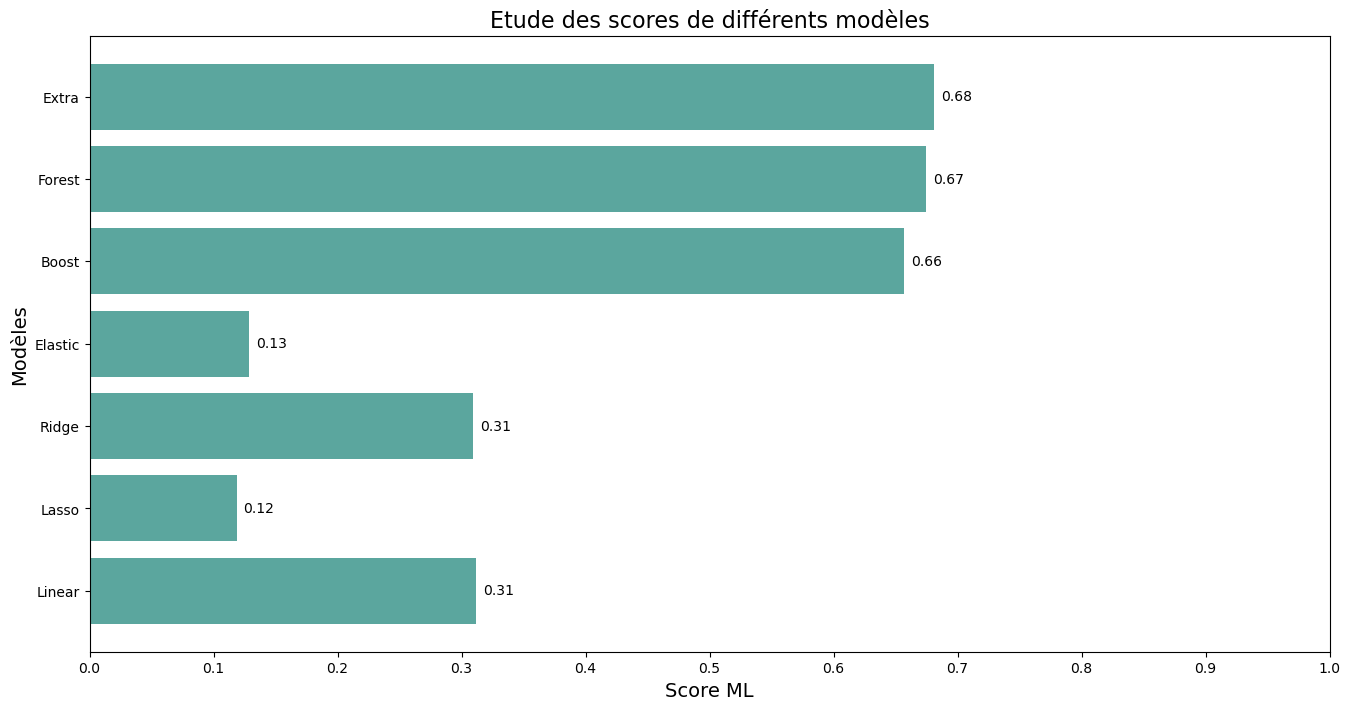

In [34]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.pipeline import Pipeline

models = [linear_model.LinearRegression(),
         linear_model.Lasso(),
         linear_model.Ridge(),
         linear_model.ElasticNet(),
         ensemble.GradientBoostingRegressor(),
         ensemble.RandomForestRegressor(),
         ensemble.ExtraTreesRegressor()]

model_names = ['Linear', 'Lasso', 'Ridge', 'Elastic', 'Boost', 'Forest', 'Extra']

scores = []
mse = []
mae = []

for model in models:
    pipe = Pipeline([('model', model)])
    fits = pipe.fit(X_train_scaled, y_train)
    scores.append(metrics.r2_score(y_test, fits.predict(X_test_scaled)))

fig, ax = plt.subplots(1,1, figsize=(16,8))
barh = ax.barh(model_names, scores, color='#5BA69E')
labels = [np.round(i,2) for i in barh.datavalues]
ax.bar_label(barh, labels=labels, padding=5)
ax.set_xticks(np.arange(0,1.1,0.1))
ax.set_xlabel('Score ML', fontsize=14)
ax.set_ylabel('Modèles', fontsize=14)
ax.set_title('Etude des scores de différents modèles', fontsize=16)
plt.show()

## MED20 ##

In [35]:
from scipy.stats import pearsonr
df_MED20 = df[df.MED20.isna() == False].reset_index(drop=True)

results_dict = {}
pvalue_dict = {}
for i in df_MED20.select_dtypes('number').columns:
    try:
        test = pearsonr(df_MED20['MED20'], df_MED20[i])
        results_dict[i] = test[0]
        pvalue_dict[i] = test[1]
    except:
        print(i)

df_results = pd.DataFrame(results_dict.items())
df_results['p_value'] = df_results[0].map(pvalue_dict)
df_results.columns = ['col','score_test', 'pvalue']
df_results.sort_values(by='score_test', ascending=False).reset_index(drop=True)

TP6020


,col,score_test,pvalue
0,MED20,1.000000,0.000000e+00
1,latitude,0.168745,1.568984e-198
2,Unnamed: 0,0.152142,2.445254e-161
3,code_postal,0.151496,5.694159e-160
4,longitude,0.146114,7.886991e-149
5,P19_ACTOCC15P_ILT5,0.137427,9.978947e-132
6,P19_ACTOCC15P_ILT2P,0.059249,9.769284e-26
7,P19_RPMAISON_ACH05,0.054767,3.206141e-22
8,P19_RPMAISON_ACH90,0.054579,4.441423e-22
9,P19_ACTOCC15P_ILT2,0.053527,2.694355e-21
